### 3. Sentiment Analysis Integration
In the work done so far, we have achieved very good results: we have thoroughly understood the nature of the data by analysing the most relevant words, we have vectorised the text in an intuitively derived manner, and we have used different models to achieve optimised performance. In conclusion, we have shown how **Logistic Regression** is an excellent technique in this context, with 94% accuracy, limited overfitting, and reasonable training time compared to more complex models.

Can we try to further improve the results? This is the intention of this notebook, through the integration of **sentiment analysis**.\
Specifically, we want to construct a feature vector for each text, consisting of the output of the Logistic Regressor (Real/Fake probabilities) and categorical features for each sentiment identified in the text. A vector will then have the following shape:
$$\left[ p(\text{real}) \;\; p(\text{fake}) \;\; \text{sentiment}_1 \;\; \text{sentiment}_2 \;\; \cdots \;\; \text{sentiment}_N \right]$$
To do so, we'll use a pretrained `torch` sentiment analysis model.

In [1]:
# Import the necessary libraries and the data 
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
# Import the custom python file sentiment.py
from sentiment import *

# Load the data and create the combined column
def fetch_data(name=''):
    df = pd.read_csv('processed_data/'+name, index_col=0)
    df.reset_index(drop=True, inplace=True)
    if 'title' in df.columns:
        df['combined'] = df['title'] + ' ' + df['text']
    return df

X_train = fetch_data('X_train.csv')
X_test = fetch_data('X_test.csv')
y_train = fetch_data('y_train.csv')
y_test = fetch_data('y_test.csv')

# Remove null values from the data
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)
# Remove the same rows from the target labels
y_train = y_train[y_train.index.isin(X_train.index)]
y_test = y_test[y_test.index.isin(X_test.index)]

# Reset the indexes
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

c:\Users\errez\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\errez\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [2]:
import joblib
import os
# Load the logistic regression model
model = joblib.load('models/logreg_best_model.pkl')

In [3]:
# If the processed data does not exist, then transform the dataset
if not os.path.exists('processed_data/X_train_final.csv'):
    # Predict the probabilities of the fake news
    fake_proba = model.predict_proba(X_train['combined'])
    # Add the probabilities to the training data
    X_train['fake_probability'] = fake_proba[:, 1]
    # Create new columns for each emotion in the training data: no need to insert both positive and negative columns since they are inversely proportional
    X_train['positive'] = 0
    X_train['sadness'] = 0
    X_train['joy'] = 0
    X_train['love'] = 0
    X_train['anger'] = 0
    X_train['fear'] = 0
    X_train['surprise'] = 0
    # Get the emotion scores for the test data
    X_train = get_sentiment_scores(X_train)

    # Save the test data
    X_train.to_csv('processed_data/X_train_final.csv')
else:
    X_train = pd.read_csv('processed_data/X_train_final.csv', index_col=0)

In [4]:
# Save the training data
X_train.to_csv('processed_data/X_train_final.csv')

In [5]:
if not os.path.exists('processed_data/X_test_final.csv'):
    # Predict the probabilities of the fake news
    fake_proba = model.predict_proba(X_test['combined'])
    # Add the probabilities to the training data
    X_test['fake_probability'] = fake_proba[:, 1]

    # Create new columns for each emotion in the test set
    X_test['positive'] = 0
    X_test['sadness'] = 0
    X_test['joy'] = 0
    X_test['love'] = 0
    X_test['anger'] = 0
    X_test['fear'] = 0
    X_test['surprise'] = 0
    
    # Get the emotion scores for the test data
    X_test = get_sentiment_scores(X_test)

    # Save the test data
    X_test.to_csv('processed_data/X_test_final.csv')
else:
    X_test = pd.read_csv('processed_data/X_test_final.csv', index_col=0)

Now look for correlations between the new features: it is indeed likely that some of them are strongly related.\
We note a significant anticorrelation between *joy* and *anger*, which, however, is not high enough to justify the removal of either feature.\
It is interesting to note a (slight) positive correlation between *positive* and *anger*, which convey different meanings.

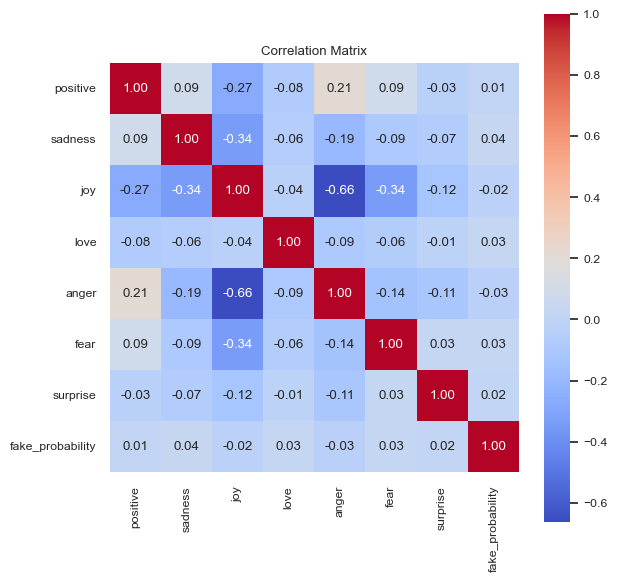

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=0.8)

num_features = ['positive', 'sadness', 'joy', 'love', 'anger', 'fear', 'surprise', 'fake_probability']

# Compute and visualize the correlation matrix
corr = X_train[num_features].corr()
plt.figure(figsize=(6.6, 6.6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Matrix')
plt.show();

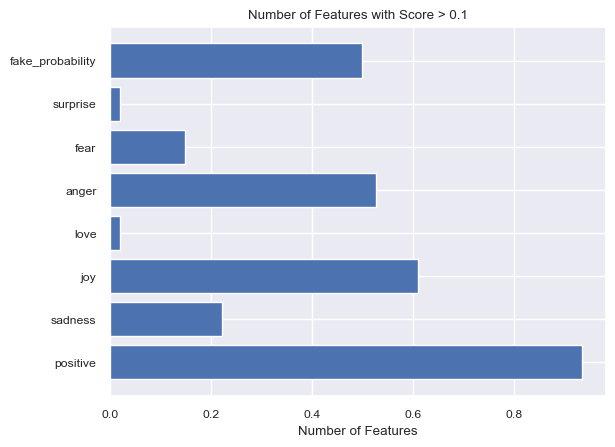

In [7]:
# Visualize the distribution of the features
mask = X_train[num_features] > 0.1
plt.barh(num_features, mask.sum(axis=0)/len(X_train))
plt.title('Number of Features with Score > 0.1')
plt.xlabel('Number of Features')
plt.show();

The fatures called *love* and *surprise* tend to have very low values. This makes sense because one hardly ever encounters these emotions in news stories. However, these features, along with *fear* and *sadness*, will not be removed because it is quite common that fake news, with a typically more heated tone, can raise the value of these ‘rare’ sentiments.

However, one problem is observed: there are too many news items with a *positive* score above 0.5, even above 0.8 (approximately 85% of the news are classified positive with 0.8 probability score). We will take this evidence into account later, and will also try to remove this feature.

In [8]:
# Too many positive news
mask = X_train[num_features] > 0.8
print(mask.sum(axis=0)/len(X_train))

positive            0.853881
sadness             0.052412
joy                 0.330554
love                0.004566
anger               0.196149
fear                0.041294
surprise            0.008735
fake_probability    0.497320
dtype: float64


Finally, train a simple neural network with this new dataset.

In [9]:
# Train a simple NN model using keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Standardize the data (only the numerical features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_features])
X_test_scaled = scaler.transform(X_test[num_features])

# Create the model, applying dropout to prevent overfitting, and building a very simple architecture
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-2), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train['label'], epochs=10, batch_size=254, validation_split=0.2, verbose=1)

Epoch 1/10
16/16 [==============================] - 3s 40ms/step - loss: 0.1117 - accuracy: 0.9444 - val_loss: 5.0745e-12 - val_accuracy: 1.0000
Epoch 2/10
16/16 [==============================] - 0s 13ms/step - loss: 0.0411 - accuracy: 0.9978 - val_loss: 0.0112 - val_accuracy: 0.9990
Epoch 3/10
16/16 [==============================] - 0s 13ms/step - loss: 0.0291 - accuracy: 0.9980 - val_loss: 9.4827e-04 - val_accuracy: 0.9990
Epoch 4/10
16/16 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 7.7072e-09 - val_accuracy: 1.0000
Epoch 5/10
16/16 [==============================] - 0s 14ms/step - loss: 1.6035e-04 - accuracy: 1.0000 - val_loss: 1.8295e-08 - val_accuracy: 1.0000
Epoch 6/10
16/16 [==============================] - 0s 14ms/step - loss: 2.8734e-07 - accuracy: 1.0000 - val_loss: 2.2833e-10 - val_accuracy: 1.0000
Epoch 7/10
16/16 [==============================] - 0s 13ms/step - loss: 4.9159e-09 - accuracy: 1.0000 - val_loss: 2.4128e-10 

In [10]:
# Evaluate the model on the test data
model.evaluate(X_test_scaled, y_test['label'])

print(classification_report(y_test['label'], model.predict(X_test_scaled) > 0.5))

40/40 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       639
           1       0.94      0.94      0.94       620

    accuracy                           0.94      1259
   macro avg       0.94      0.94      0.94      1259
weighted avg       0.94      0.94      0.94      1259



The results are not much better than with simple logistic regression. This is probably associated with the insignificance of the new features, which add only a limited degree of depth: let us therefore try to make these variables more meaningful by performing the sentiment analysis on unprocessed texts.

#### 5.1 Sentiment Analysis on non-processed texts
Sentiment analysis can sometimes perform better on non-processed texts because the context provided by punctuation, stopwords, and frequent words can be crucial for understanding the emotional tone of the text. These elements can contribute to the nuances of sentiment that might be lost during preprocessing. Conclude the project with this last modification.

In [11]:
# Get the original data
data = pd.read_csv('data/news.csv', index_col=0)

In [12]:
# Clean the data
data.dropna(inplace=True)

# Reset the index
data.reset_index(drop=True, inplace=True)

In [13]:
if not os.path.exists('processed_data/data_final_unprocessed.csv'):
    # Prepare the dataframe for the sentiment analysis
    sentiments = ['positive', 'sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
    for s in sentiments:
        data['title_'+s] = 0
        data['text_'+s] = 0

    # Get the sentiment scores - titles
    data = get_title_sentiment_scores(data)
    # Get the sentiment scores - texts
    data = get_text_sentiment_scores(data)

    # Save the data
    data.to_csv('processed_data/data_final_unprocessed.csv')
else:
    data = pd.read_csv('processed_data/data_final_unprocessed.csv', index_col=0)

# Load the data
data = pd.read_csv('processed_data/data_final_unprocessed.csv', index_col=0)

Title processing:   0%|                              | 0/6335 [00:00<?, ?it/s]

Text processing: 100%|██████████████████████████████| 6335/6335 [1:01:18<00:00,  1.72it/s]


In [25]:
# Create the combined column
data['combined'] = data['title'] + ' ' + data['text']
data.drop(columns=['title', 'text'], axis=1, inplace=True)

data.dropna(inplace=True)

In [27]:
# Load the logistic regression model
model = joblib.load('models/logreg_best_model.pkl')

In [28]:
# Predict the probabilities of the fake news
fake_proba = model.predict_proba(data['combined'])
# Add the probabilities to the training data
data['fake_probability'] = fake_proba[:, 1]

In [33]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[data.columns[1:]], data['label'], test_size=0.2, random_state=42)

# Preprocess the text data
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK datasets
if not nltk.data.find('corpora/stopwords'):
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')

# Define the english stopwords
stop_words = set(stopwords.words('english'))
# Define the lemmatizer, which reduces words to their base or root form
lemmatizer = WordNetLemmatizer()

# Function that tokenizes, removes stopwords, and lemmatizes the text
def process_text(text):
    tokens = word_tokenize(text.lower())
    # Remove non-alphabetic characters
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize the words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply the function to the title and text columns
X_train['combined'] = X_train['combined'].apply(process_text)
X_test['combined'] = X_test['combined'].apply(process_text)

In [35]:
# Remove the fake_probability column
X_train.drop(columns=['combined'], axis=1, inplace=True)

In [36]:
# Look at the structure of the data: it is the same as before, except that the numerical sentiment values were obtained on unprocessed text and title data
X_train.head()

,title_positive,text_positive,title_sadness,text_sadness,title_joy,text_joy,title_love,text_love,title_anger,text_anger,title_fear,text_fear,title_surprise,text_surprise,fake_probability
1142,0.885711,0.011598,0.030620,0.019497,0.328096,0.300353,0.026289,0.011667,0.573996,0.648832,0.036563,0.016123,0.004436,0.003529,0.104554
2654,0.001455,0.995341,0.003349,0.000721,0.988181,0.000456,0.001532,0.000525,0.005023,0.997389,0.001193,0.000541,0.000721,0.000369,0.999450
5395,0.984931,0.815639,0.002417,0.001170,0.002483,0.001442,0.001752,0.000650,0.481695,0.931490,0.507962,0.064268,0.003691,0.000979,0.991897
1170,0.011554,0.995077,0.015937,0.008901,0.073411,0.973087,0.010630,0.002787,0.889918,0.011289,0.008427,0.003129,0.001676,0.000806,0.997489
4371,0.974818,0.995193,0.005565,0.002509,0.004713,0.001799,0.002290,0.001525,0.767689,0.209166,0.217008,0.781428,0.002735,0.003574,0.981764


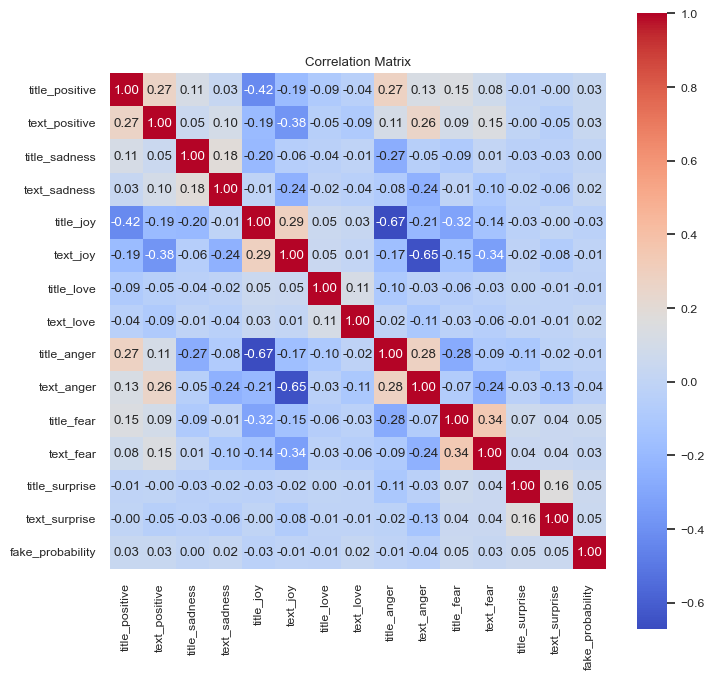

In [39]:
# Inspect the correlation matrix, as before
corr = X_train.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Matrix')
plt.show();

The results are very similar to before, but here we can appreciate a strange occurrence: the correlation between the same sentiment extracted from the title and the text is relatively low, sometimes even turning into anti-correlation. The reason is quickly explained: titles contain far fewer words and it only takes one word with a negative meaning to alter the interpretation of the title itself. For this reason, we also try to remove the features related to titles.

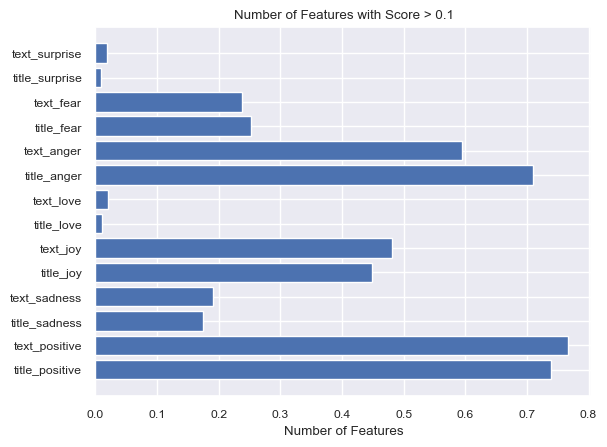

In [47]:
# Visualize the distribution of the features
features = [f for f in X_train.columns if f != 'fake_probability']
mask = X_train[features] > 0.1
plt.barh(features, mask.sum(axis=0)/len(X_train))
plt.title('Number of Features with Score > 0.1')
plt.xlabel('Number of Features')
plt.show();

Once again *surprise* and *love* assume very low average values. Instead, we notice an increase on the other sentiments: even setting the limit to 0.5, we get more *fear*, *anger*, *joy* and *sadness*. Setting the limit to 0.8, *positive* slightly exceeds 0.6, thus being much more balanced than in the previous case.

In [48]:
# More balanced number of positive news, higher number of other sentiments
mask = X_train[features] > 0.8
print(mask.sum(axis=0)/len(X_train))

title_positive    0.623520
text_positive     0.641476
title_sadness     0.033741
text_sadness      0.045185
title_joy         0.190805
text_joy          0.248421
title_love        0.001184
text_love         0.002762
title_anger       0.307616
text_anger        0.273283
title_fear        0.049724
text_fear         0.059787
title_surprise    0.000789
text_surprise     0.006117
dtype: float64


In [59]:
X_test.head()

,title_positive,text_positive,title_sadness,text_sadness,title_joy,text_joy,title_love,text_love,title_anger,text_anger,title_fear,text_fear,title_surprise,text_surprise,fake_probability
1357,0.001083,0.018873,0.934745,0.007939,0.021564,0.867106,0.003212,0.009981,0.021219,0.072849,0.017414,0.040005,0.001846,0.002120,0.994629
2080,0.995351,0.997959,0.007509,0.785707,0.002050,0.004188,0.001454,0.001023,0.748824,0.205527,0.238777,0.002896,0.001386,0.000661,0.998606
2718,0.999467,0.980513,0.017341,0.038512,0.059232,0.781123,0.005506,0.111908,0.814922,0.065031,0.099881,0.002123,0.003117,0.001302,0.998304
812,0.054717,0.984641,0.001770,0.186403,0.992732,0.269546,0.002309,0.006238,0.002224,0.294506,0.000573,0.239822,0.000391,0.003485,0.919913
4886,0.989520,0.997074,0.005242,0.014052,0.001183,0.001520,0.001844,0.001881,0.226533,0.195591,0.761585,0.782257,0.003614,0.004699,0.985914


In [62]:
# Transform y_train and y_test: FAKE = 1, REAL = 0
y_train = y_train.map({'FAKE': 1, 'REAL': 0})
y_test = y_test.map({'FAKE': 1, 'REAL': 0})

# Remove the combined column from the test data
X_test.drop(columns=['combined'], axis=1, inplace=True)

In [68]:
# Standardize the data (only the numerical features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the model, applying dropout to prevent overfitting, and building a very simple architecture
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=254, validation_split=0.2, verbose=1)

Epoch 1/10
16/16 [==============================] - 1s 21ms/step - loss: 0.4510 - accuracy: 0.8890 - val_loss: 0.1378 - val_accuracy: 0.9872
Epoch 2/10
16/16 [==============================] - 0s 7ms/step - loss: 0.0830 - accuracy: 0.9850 - val_loss: 0.0287 - val_accuracy: 0.9911
Epoch 3/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0414 - accuracy: 0.9899 - val_loss: 0.0253 - val_accuracy: 0.9951
Epoch 4/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0428 - accuracy: 0.9884 - val_loss: 0.0224 - val_accuracy: 0.9941
Epoch 5/10
16/16 [==============================] - 0s 8ms/step - loss: 0.0401 - accuracy: 0.9889 - val_loss: 0.0251 - val_accuracy: 0.9951
Epoch 6/10
16/16 [==============================] - 0s 8ms/step - loss: 0.0288 - accuracy: 0.9936 - val_loss: 0.0199 - val_accuracy: 0.9951
Epoch 7/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0271 - accuracy: 0.9926 - val_loss: 0.0234 - val_accuracy: 0.9951
Epoch 8/10
16/16 [=

In [69]:
# Evaluate the model on the test data
model.evaluate(X_test_scaled, y_test)

40/40 [==============================] - 0s 3ms/step - loss: 0.3572 - accuracy: 0.9250


[0.35724031925201416, 0.9250197410583496]

Performance has not yet improved. We try to train the model only on the features extracted from the texts, as we have seen how these often contradict those derived from the titles.

In [77]:
text_features = ['text_' + s for s in sentiments] + ['fake_probability']
title_features = ['title_' + s for s in sentiments] + ['fake_probability']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[text_features])
X_test_scaled = scaler.transform(X_test[text_features])

# Create the model, applying dropout to prevent overfitting, and building a very simple architecture
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=254, validation_split=0.2, verbose=1)

Epoch 1/10
16/16 [==============================] - 1s 21ms/step - loss: 0.4013 - accuracy: 0.9161 - val_loss: 0.1207 - val_accuracy: 0.9803
Epoch 2/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0612 - accuracy: 0.9882 - val_loss: 0.0249 - val_accuracy: 0.9931
Epoch 3/10
16/16 [==============================] - 0s 8ms/step - loss: 0.0330 - accuracy: 0.9911 - val_loss: 0.0223 - val_accuracy: 0.9931
Epoch 4/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0283 - accuracy: 0.9936 - val_loss: 0.0187 - val_accuracy: 0.9961
Epoch 5/10
16/16 [==============================] - 0s 8ms/step - loss: 0.0274 - accuracy: 0.9931 - val_loss: 0.0174 - val_accuracy: 0.9951
Epoch 6/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0253 - accuracy: 0.9924 - val_loss: 0.0181 - val_accuracy: 0.9961
Epoch 7/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0290 - accuracy: 0.9924 - val_loss: 0.0194 - val_accuracy: 0.9961
Epoch 8/10
16/16 [=

In [78]:
model.evaluate(X_test_scaled, y_test)

40/40 [==============================] - 0s 3ms/step - loss: 0.3568 - accuracy: 0.9266


[0.356759250164032, 0.9265982508659363]

In [79]:
# Let's try with only the title_features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[title_features])
X_test_scaled = scaler.transform(X_test[title_features])

# Create the model, applying dropout to prevent overfitting, and building a very simple architecture
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=254, validation_split=0.2, verbose=1)

Epoch 1/10
16/16 [==============================] - 2s 23ms/step - loss: 0.4074 - accuracy: 0.9240 - val_loss: 0.0903 - val_accuracy: 0.9892
Epoch 2/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0607 - accuracy: 0.9909 - val_loss: 0.0243 - val_accuracy: 0.9931
Epoch 3/10
16/16 [==============================] - 0s 11ms/step - loss: 0.0385 - accuracy: 0.9904 - val_loss: 0.0193 - val_accuracy: 0.9941
Epoch 4/10
16/16 [==============================] - 0s 11ms/step - loss: 0.0276 - accuracy: 0.9936 - val_loss: 0.0182 - val_accuracy: 0.9941
Epoch 5/10
16/16 [==============================] - 0s 11ms/step - loss: 0.0298 - accuracy: 0.9931 - val_loss: 0.0292 - val_accuracy: 0.9941
Epoch 6/10
16/16 [==============================] - 0s 12ms/step - loss: 0.0301 - accuracy: 0.9928 - val_loss: 0.0171 - val_accuracy: 0.9941
Epoch 7/10
16/16 [==============================] - 0s 12ms/step - loss: 0.0252 - accuracy: 0.9931 - val_loss: 0.0172 - val_accuracy: 0.9961
Epoch 8/10
16

In [80]:
model.evaluate(X_test_scaled, y_test)

40/40 [==============================] - 0s 3ms/step - loss: 0.3313 - accuracy: 0.9305


[0.33129605650901794, 0.9305446147918701]

### Conclusions
We summarise the results obtained:
1. The best Logistic Regression model yielded an accuracy of 93.9%, using only text and news titles.
2. The classification model performs better on a naive combination of titles and texts.
3. Other models achieve similar results but, given the high computational cost, the simple Logistic Regression (LR) is chosen. The worst model is the Naive Bayes, with accuracy below 90%.
4. Exploiting Sentiment Analysis to construct feature vectors proved to be generally useless or even counter-productive: performing SA on the processed texts combined with the titles yields a result very similar to that with the simple LR, around 93.9%. Performing SA on unprocessed texts, on the other hand, which should be more accurate, even proved negative for the performance of the classifier, reaching a maximum accuracy of 93%.

The results of this study certainly leave room for interpretation: we have shown that TFIDF vectorisation is the most natural strategy for the transformation of this type of text, in which the frequency of certain words plays a key role. We also showed how to obtain a text structure that is suitable for classification by means of Logistic Regression, which proved to be absolutely sufficient to achieve excellent performance. Note that no use was made of LSTM or transformers, i.e. the model was not actually trained to recognise the structure of texts, but rather their composition according to TFIDF vectorisation. This fact opens up a relevant question: **in the binary classification between real and fake news, it is not crucial to ‘understand’ the texts**, but more to recognise the most frequent words and their combinations up to bigrams. Why? The next part enlightens us in this regard.

Of course, one would think that analysing texts in depth by means of Sentiment Analysis would add degrees of information in the dataset. Therefore, the output of SA, combined with the predictions of the model trained on the texts, could help achieve higher accuracy. Is this really a logically valid assumption? Yes, if the SA produces an output *relevant* to the classification. For example, suppose we want to distinguish between a positive/negative review of a film from the text of the review: clearly the SA with positive/negative output would be very useful.\
In fake news detection, however, this is not quite the case. In particular, the addition of SA output starts from an assumption: **fake news is more ‘emotional’**, sometimes aggressive.

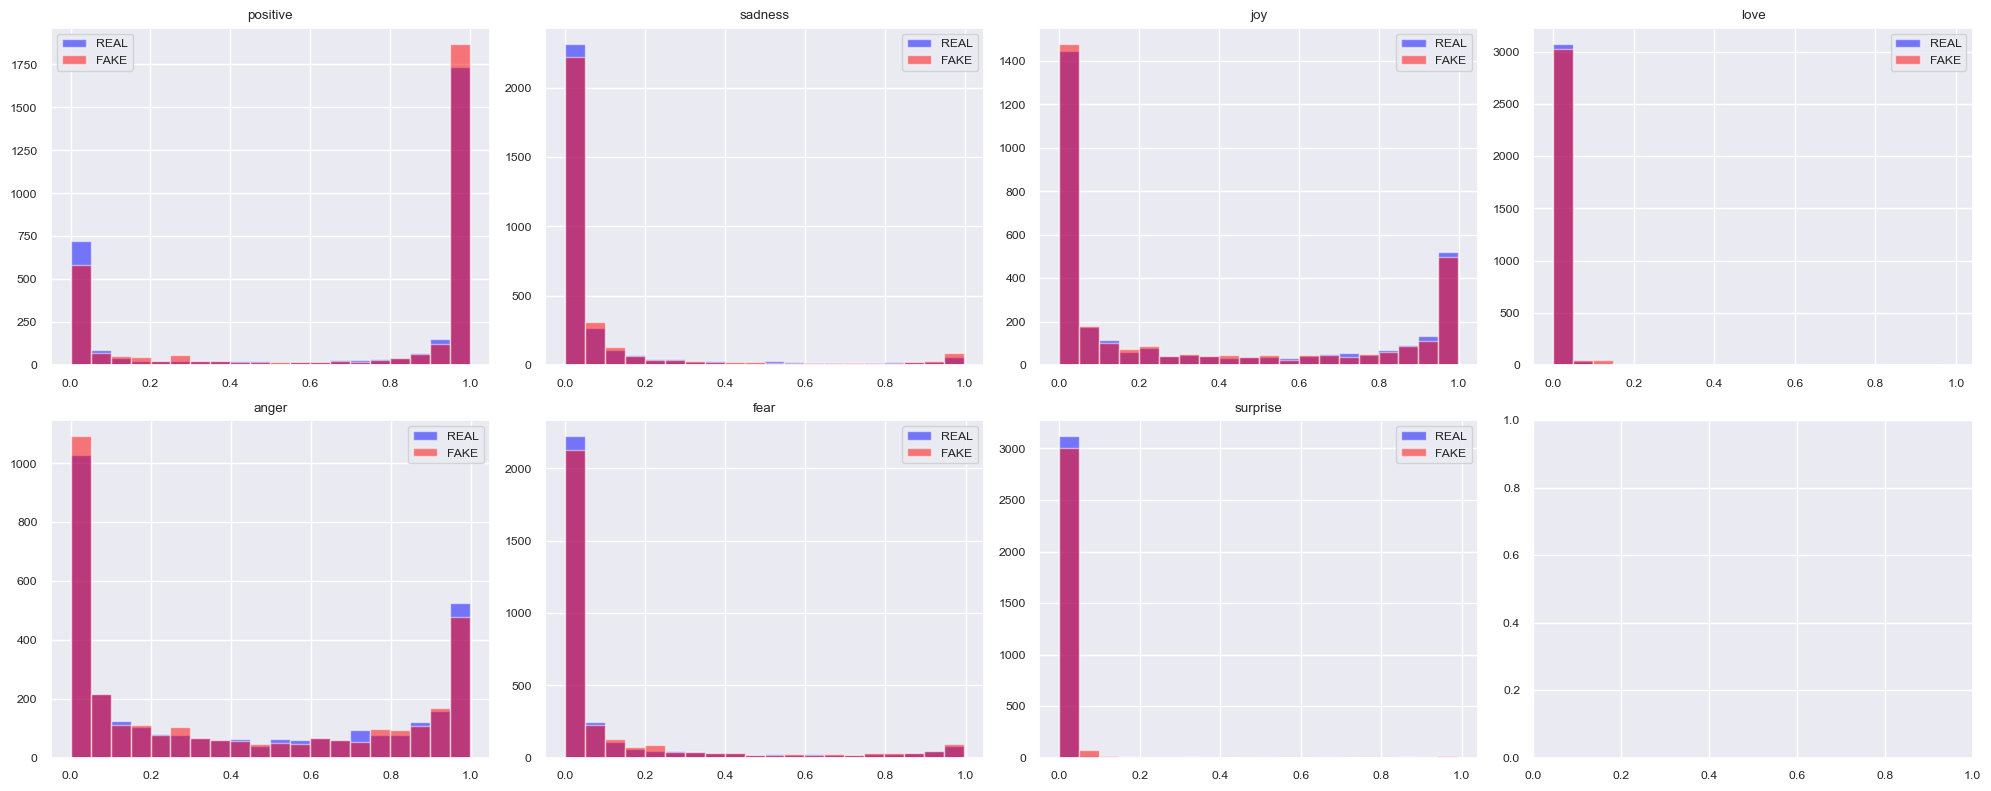

In [100]:
# Plot histograms of all the text sentiments for fake and real news
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for i, s in enumerate(sentiments):
    ax[i//4, i%4].hist(data[data['label'] == 'REAL']['text_'+s], bins=20, alpha=0.5, label='REAL', color='blue')
    ax[i//4, i%4].hist(data[data['label'] == 'FAKE']['text_'+s], bins=20, alpha=0.5, label='FAKE', color='red')
    ax[i//4, i%4].set_title(s)
    ax[i//4, i%4].legend()

plt.tight_layout()
plt.show();

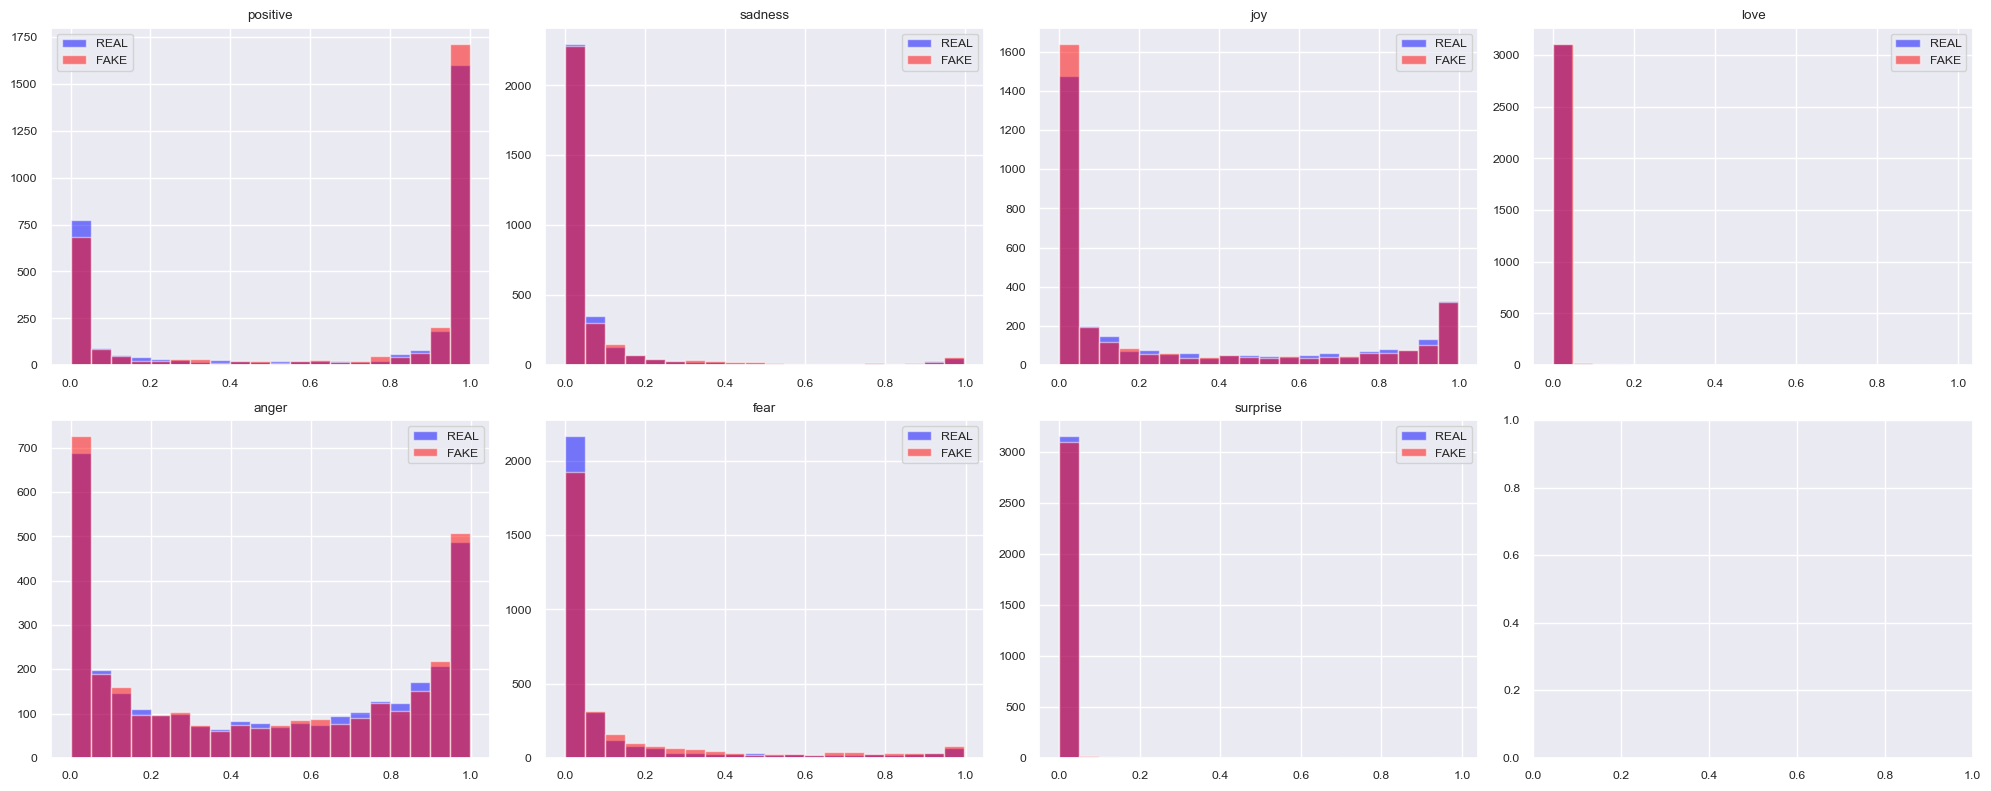

In [101]:
# Plot histograms of all the title sentiments for fake and real news
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for i, s in enumerate(sentiments):
    ax[i//4, i%4].hist(data[data['label'] == 'REAL']['title_'+s], bins=20, alpha=0.5, label='REAL', color='blue')
    ax[i//4, i%4].hist(data[data['label'] == 'FAKE']['title_'+s], bins=20, alpha=0.5, label='FAKE', color='red')
    ax[i//4, i%4].set_title(s)
    ax[i//4, i%4].legend()

plt.tight_layout()
plt.show();

From these plots we see how this assumption has no reason to exist: the ‘sentimental’ distribution of news does not follow the division between real and fake news at all. In these plots, we would indeed expect red peaks (fake news) on higher sentiment values, but instead we observe a complete overlap between real and fake news distributions. This explains why the process did not work. Basically, **SA does not add any degree of information and the performance remains almost unchanged**.

In tasks involving text classification, the addition of information such as that derived from SA is often encouraged: here we found that before doing so, it is good to consider the nature of the data. In fake news detection, this information adds nothing, and indeed risks even compromising the results. The most plausible conclusion is the following: the SA we used was not explicitly trained on news texts, so its predictive power is less reliable. SA provides an essentially irrelevant sentiment score for classification tasks. Furthermore, the fact that TFIDF vectorization performs better in the case of a trivial combination of titles and texts tells us that the structure of the text is of little relevance: what matters is the composition of the text, in terms of the lemmas used and certain combinations between them. 